# This file is just toying with some various implementations of Bayesian regression in python

Note - we will need to create some mapping from "Celtics" to "BOS" in order to make use of the team ratings that Willis created.

In [127]:
import pymc3 as pm
import pandas as pd
import numpy as np

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")

data.head()

,Unnamed: 0,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,...,519,520,521,522,523,524,525,526,527,528
0,0,-0.364583,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.390625,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-0.723380,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-0.361690,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.382966,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Toy Example

Below we fit a very small Bayesian regression model with some specified priors (chosen arbitrarily). We regress the first 100 point differentials on the first 100 rows of our shifts dataset, only considering players 0-3. Thus, the dimensionality of this toy example is far smaller than our final model will be, but the methodology should be similar. Of course, we will also need to adjust the priors and make them far more meaningful and player specific as this is the main purpose of this project.

In [123]:
x_df = data.iloc[:,1:6][:10]
x_df.columns = ["point_diff", "p0", "p1", "p2", "p3"]

x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_prior_means = np.array([10, -1, 25, -12])
    x_prior_sigmas = np.array([6,6,6,6])
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = 4)
    
    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y)

    trace = pm.sample(1000, tune = 1000, cores = 1)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in ? (vectorized)
  
/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/theano/scalar/basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 104 seconds.
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.207980409633183, but should be close to 0.8. Try to increase the number of tuning steps.
There were 883 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5784951576384444, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'x\n0'}>,
        <AxesSubplot:title={'center':'x\n1'}>],
       [<AxesSubplot:title={'center':'x\n2'}>,
        <AxesSubplot:title={'center':'x\n3'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

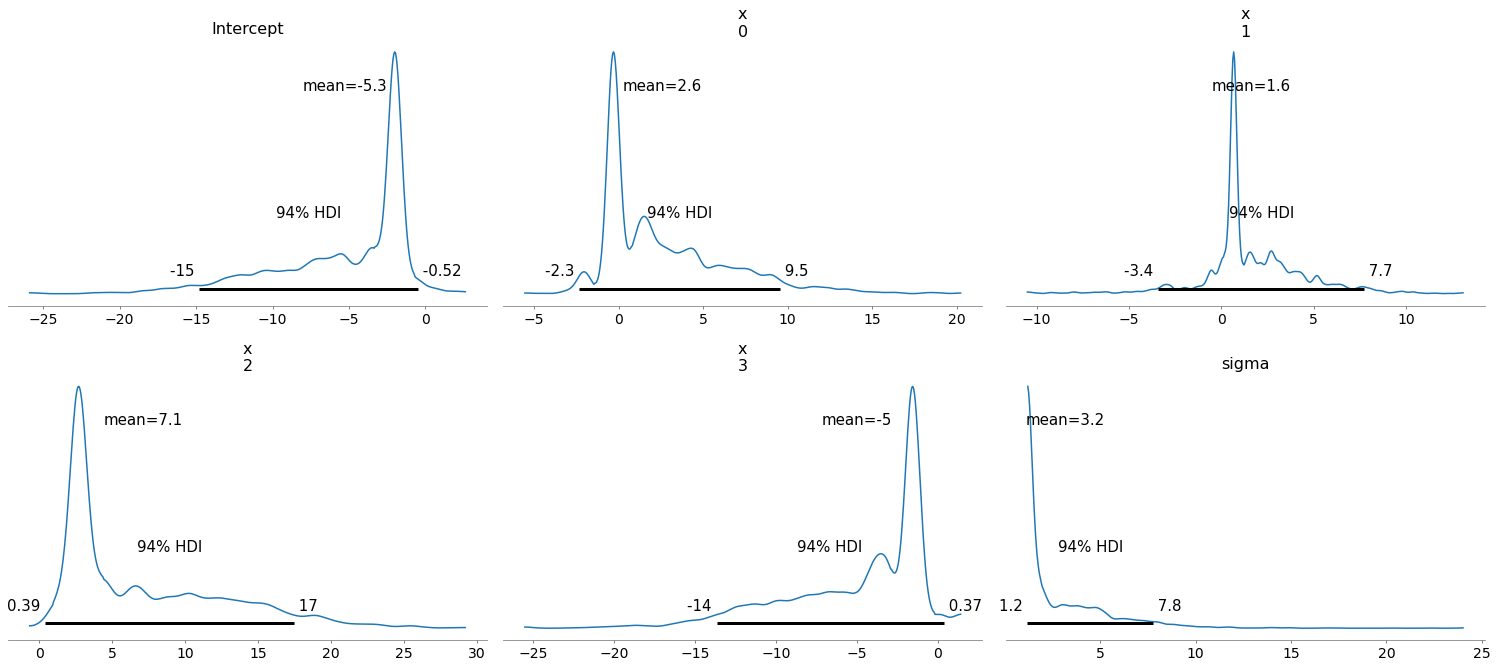

In [124]:
# This plots the distributions for the intercept, error (sigma), and the various x coefficients
pm.plot_posterior(trace)

In [118]:
# This gives us the mean and sd of each coefficient in a nicely formatted dataframe
pm.summary(trace, kind="stats")

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
Intercept,-0.020,0.101,-0.210,0.167
x[0],0.162,0.325,-0.478,0.754
x[1],-0.291,0.298,-0.840,0.269
x[2],-0.291,0.283,-0.831,0.218
x[3],0.113,0.333,-0.490,0.738
sigma,0.877,0.063,0.761,0.994


In [126]:
tmp = trace.get_values("x") # This gets all 1000 samples for each variable, then we can get mean and sd from here
np.mean(tmp, axis = 0)
np.std(tmp, axis = 0)
# This was just to verify the results in the above dataframe

array([3.72341036, 2.76280493, 5.59896683, 4.36760699])